In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# === 2. Build MobileNetV1 From Scratch ===
def build_mobilenet_v1(input_shape=(224, 224, 3), num_classes=4):
    def depthwise_separable_conv(x, pointwise_filters, strides):
        x = layers.DepthwiseConv2D(kernel_size=3, padding='same', strides=strides)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(6.)(x)
        x = layers.Conv2D(pointwise_filters, kernel_size=1)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(6.)(x)
        return x

    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.)(x)

    # Depthwise separable blocks
    x = depthwise_separable_conv(x, 64, strides=1)
    x = depthwise_separable_conv(x, 128, strides=2)
    x = depthwise_separable_conv(x, 128, strides=1)
    x = depthwise_separable_conv(x, 256, strides=2)
    x = depthwise_separable_conv(x, 256, strides=1)
    x = depthwise_separable_conv(x, 512, strides=2)
    for _ in range(5):
        x = depthwise_separable_conv(x, 512, strides=1)
    x = depthwise_separable_conv(x, 1024, strides=2)
    x = depthwise_separable_conv(x, 1024, strides=1)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=input_layer, outputs=x)

2025-05-25 10:15:41.587697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748168141.816628      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748168141.872706      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- Directory Setup ---
base_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir  = os.path.join(base_dir, 'test')

# --- Parameters ---
img_size = (224, 224)
batch_size = 16
num_classes = 4

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    channel_shift_range=20,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=True
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

# Assuming y_train contains the class labels
# Print class distribution
# y_train = train_generator.classes
# class_counts = Counter(y_train)
# print("Class distribution in y_train:")
# for label, count in class_counts.items():
#     print(f"{label}: {count}")

# # Optional: visualize
# plt.bar(class_counts.keys(), class_counts.values())
# plt.title("Class Distribution")
# plt.xlabel("Class")
# plt.ylabel("Count")
# plt.show()

# print("Sample y_train labels:", y_train[:260])
# print("Unique labels in y_train:", np.unique(y_train))

Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [3]:
model = build_mobilenet_v1()

# === 3. Compile and Train ===
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()

# --- EarlyStopping Callback ---
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True,
#     verbose=1
# )

# --- Train the Model ---
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    # callbacks=[early_stop]
)

I0000 00:00:1748168155.801502      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1748168181.444831     117 service.cc:148] XLA service 0x795118118a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748168181.445664     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748168183.615402     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748168187.091020     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748168187.290140     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 1/63 ━━━━━━━━━━━━━━━━━━━━ 36:50 36s/step - accuracy: 0.1875 - loss: 1.3822

I0000 00:00:1748168193.832300     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 69s 532ms/step - accuracy: 0.2515 - loss: 1.5735 - val_accuracy: 0.1667 - val_loss: 1.5572
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.2776 - loss: 1.4618 - val_accuracy: 0.1667 - val_loss: 1.9768
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.2685 - loss: 1.4531 - val_accuracy: 0.1667 - val_loss: 1.8466
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.2745 - loss: 1.4318 - val_accuracy: 0.1667 - val_loss: 2.0327
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.2869 - loss: 1.4079 - val_accuracy: 0.2778 - val_loss: 1.5828
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.3278 - loss: 1.4012 - val_accuracy: 0.1667 - val_loss: 1.6832
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.3099 - loss: 1.3723 - val_accuracy: 0.1667 - val_loss: 1.9480
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.3356 - loss: 1.3745 - val_accuracy

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 762ms/step - accuracy: 0.4215 - loss: 2.1890

Test Accuracy: 0.4211


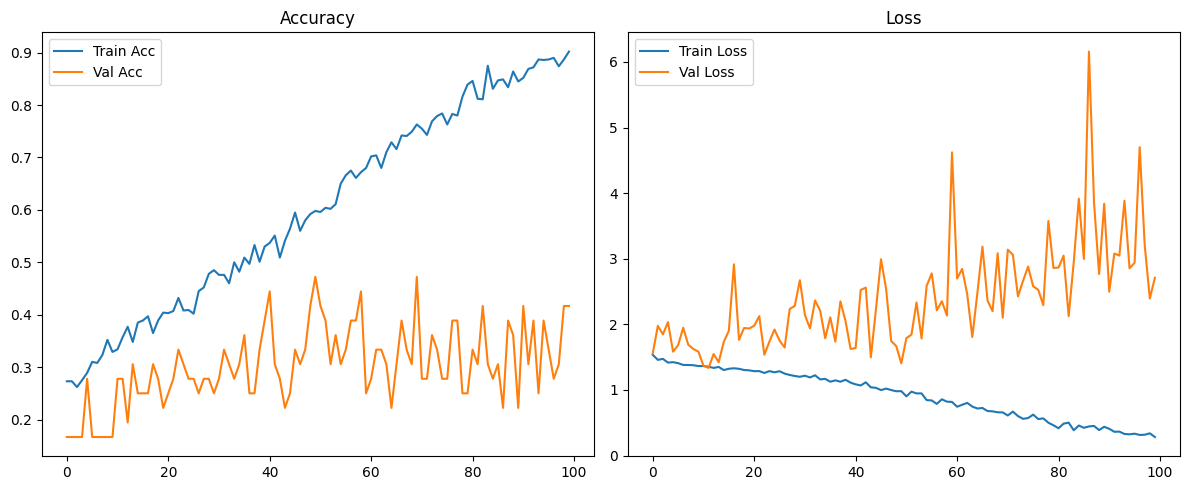

In [4]:
# --- Evaluate ---
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

# --- Plot History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

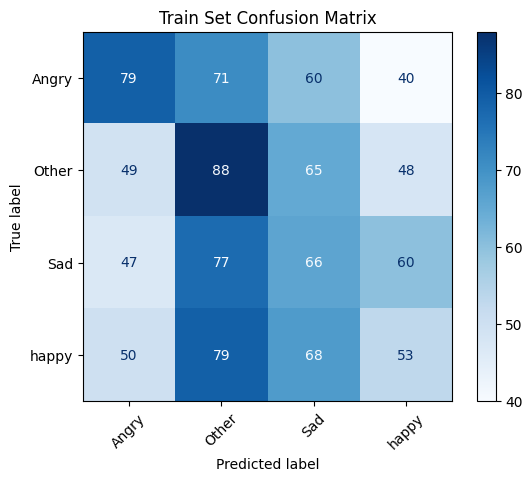

Classification Report - Train Set
              precision    recall  f1-score   support

       Angry     0.3511    0.3160    0.3326       250
       Other     0.2794    0.3520    0.3115       250
         Sad     0.2548    0.2640    0.2593       250
       happy     0.2637    0.2120    0.2350       250

    accuracy                         0.2860      1000
   macro avg     0.2872    0.2860    0.2846      1000
weighted avg     0.2872    0.2860    0.2846      1000



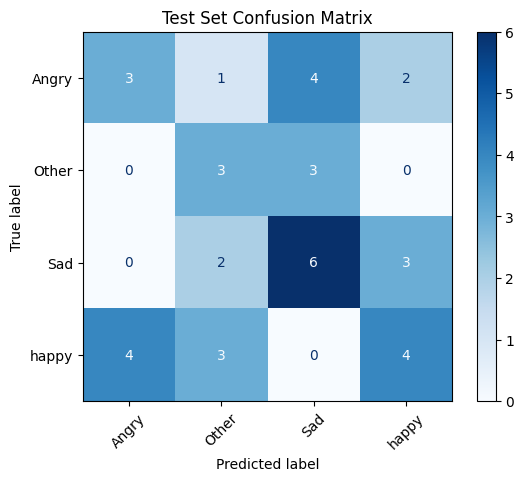

Classification Report - Test Set
              precision    recall  f1-score   support

       Angry     0.4286    0.3000    0.3529        10
       Other     0.3333    0.5000    0.4000         6
         Sad     0.4615    0.5455    0.5000        11
       happy     0.4444    0.3636    0.4000        11

    accuracy                         0.4211        38
   macro avg     0.4170    0.4273    0.4132        38
weighted avg     0.4277    0.4211    0.4166        38



In [5]:
# --- Confusion Matrix & Report ---
def evaluate_generator(gen, title):
    gen.reset()
    y_pred_probs = model.predict(gen, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = gen.classes
    class_names = list(gen.class_indices.keys())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{title} Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

    print(f"Classification Report - {title}")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

evaluate_generator(train_generator, "Train Set")
evaluate_generator(test_generator, "Test Set")